# Homework 3 (100 points)

The goal of this homework is to practice techniques relating to GMM and SVD.

## Exercise 1 (25 points)

In this exercise we will implement 1-dimensional GMM clustering algorithm from scratch. A GMM distribution is composed of `k` components, each characterized by:

1. A mixture proportion
2. A mean for its Normal Distribution
3. A variance for its Normal Distribution

So, to generate a dataset that follows a GMM dsitrbution we need a list of those parameters. In this exercise we will use a class called `Component` to capture the parameters for a given component. And a GMM will be a list of `Component`s.

In [137]:
class Component:
    def __init__(self, mixture_prop, mean, variance):
        self.mixture_prop = mixture_prop
        self.mean = mean
        self.variance = variance

example_gmm = [Component(.5, 5, 1), Component(.5, 8, 1)]

a) Complete the function below to validate and generate a dataset following a GMM distribution, given a specified set of GMM parameters as above and a size. You may only use the methods already imported in the cell. (10pts)

In [138]:
from numpy.random import normal, uniform

def generate_gmm_dataset(gmm_params, size):
    if not is_valid_gmm(gmm_params):
        raise ValueError("GMM parameters are invalid")
    dataset = []
    for _ in range(size):
        comp = get_random_component(gmm_params)
        sample = normal(comp.mean, comp.variance)
        dataset.append(sample)
    return np.array(dataset)

def is_valid_gmm(gmm_params):
    '''
        Checks that the sum of the mixture
        proportions is 1
    '''
    mixture_sum = sum(component.mixture_prop for component in gmm_params)
    return mixture_sum==1

def get_random_component(gmm_params):
    '''
        returns component with prob
        proportional to mixture_prop
    '''
    probabilities = [component.mixture_prop for component in gmm_params]
    random_component = random.choices(gmm_params, weights=probabilities)[0]
    return random_component

# test your code: this should return a list of 10 numbers similar to worksheet 8
data = generate_gmm_dataset(example_gmm, 10)
print(data)

[3.62211775 9.95806799 5.41805866 7.73217352 5.04030365 4.06362856
 5.19917252 5.73501572 8.24340845 2.93979767]


b) Finish the implementation below of the Expectation-Maximization Algorithm. Only use methods that have been imported in the cell. (15pts)

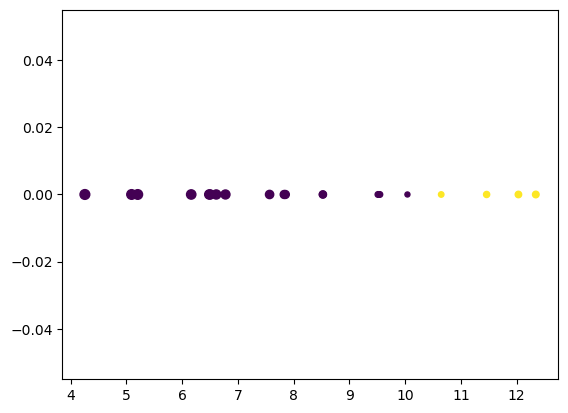

In [149]:
from scipy.stats import norm
from numpy import array, argmax
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def gmm_init(k, dataset):
    kmeans = KMeans(k, init='k-means++').fit(X=array(dataset).reshape(-1, 1))
    gmm_params = []
    # -------------------------------------------------------
    for i in range(k):
        cluster_data = dataset[kmeans.labels_ == i]
        gmm_params.append(Component(len(cluster_data)/len(dataset), cluster_data.mean(), cluster_data.var()))
    # -------------------------------------------------------
    return gmm_params


def compute_gmm(k, dataset, probs):
    '''
        Compute P(C_j), mean_j, var_j
    '''
    gmm_params = []
    # -------------------------------------------------------
    length = len(dataset)
    for j in range(k):
        prop_j = sum(probs[i][j] for i in range(length)) / length
        mean_j = sum(probs[i][j] * dataset[i] for i in range(length)) / sum(probs[i][j] for i in range(length))
        var_j = sum(probs[i][j] * (dataset[i] - mean_j) ** 2 for i in range(length)) / sum(probs[i][j] for i in range(length))
        gmm_params.append(Component(prop_j, mean_j, var_j))
    # -------------------------------------------------------
    return gmm_params


def compute_probs(k, dataset, gmm_params):
    '''
        For all x_i in dataset, compute P(C_j | X_i)
        = P(X_i | C_j)P(C_j) / P(X_i) for all C_j
        return the list of lists of all P(C_j | X_i)
        for all x_i in dataset.
    '''
    probs = []
    # -------------------------------------------------------
    for x in dataset:
        a = sum(norm.pdf(x, component.mean, component.variance) * component.mixture_prop for component in gmm_params)
        b = [norm.pdf(x, component.mean, component.variance) * component.mixture_prop / a for component in gmm_params]
        probs.append(b)
    # -------------------------------------------------------
    return probs


def expectation_maximization(k, dataset, iterations):
    '''
        Repeat for a set number of iterations.
    '''
    gmm_params = gmm_init(k, dataset)
    for _ in range(iterations):
        # expectation step
        probs = compute_probs(k, dataset, gmm_params)

        # maximization step
        gmm_params = compute_gmm(k, dataset, probs)

    return probs, gmm_params


# for testing: you should see smaller sized points
# near the boundary of a cluster if it is close to another cluster
probs, gmm_p = expectation_maximization(2, data, 3)
labels = [argmax(array(p)) for p in probs] # create a hard assignment
size = 50 * array(probs).max(1) ** 2  # square to emphasize the difference
plt.scatter(data, [0.0 for _ in range(len(data))], c=labels, cmap='viridis', s=size)
plt.show()

Notes:

1. your code should work with any number of components, each with reasonable parameters.
2. your code should work for 1 to about 5 iterations of the EM algorithm. It may not work for iterations over 10 because the math we are doing may overflow and create `nans` - that's ok / don't worry about it.
3. worksheet 7 is your friend

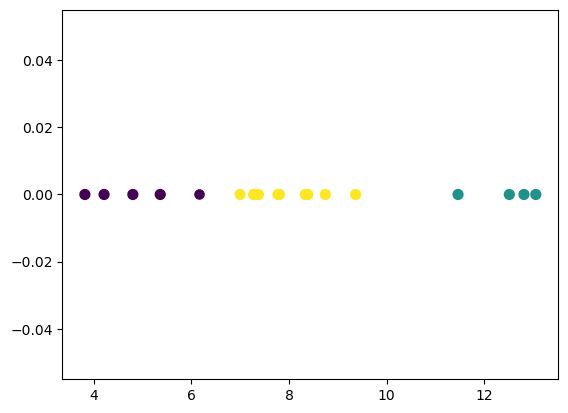

In [150]:
example_gmm = [Component(.2, 5, 1), Component(.5, 8, 1), Component(.3, 12, 1)]
data = generate_gmm_dataset(example_gmm, 20)
probs, gmm_p = expectation_maximization(3, data, 4)
labels = [argmax(array(p)) for p in probs] # create a hard assignment
size = 50 * array(probs).max(1) ** 2  # square to emphasize the difference
plt.scatter(data, [0.0 for _ in range(len(data))], c=labels, cmap='viridis', s=size)
plt.show()

## Exercise 2 (50 points)

a) Fetch the "mnist_784" data and store is as a `.csv` (that way you don't have to fetch it every time - which takes about 30s). (2.5 points)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=False)

# your code here
pd.DataFrame(X).to_csv('data.csv')
pd.DataFrame(y).to_csv('labels.csv')
data = X

b) Plot the singular value plot for a single example of the 0 digit (2.5 points)

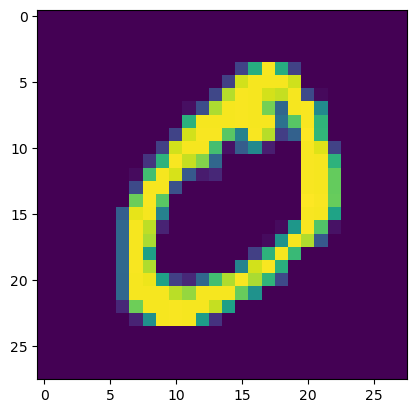

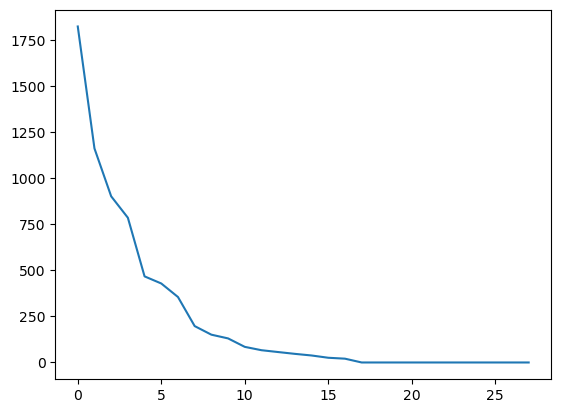

In [6]:
im = np.array(data[1]).reshape(28, 28)
plt.imshow(im)
plt.show()

u, s, v = np.linalg.svd(im, full_matrices = False)
plt.plot(s)
plt.show()

c) Just like we did in class with the image of the boat: By setting some singular values to 0, plot the approximation of an image of a 0 digit next to the original image. (10 points)

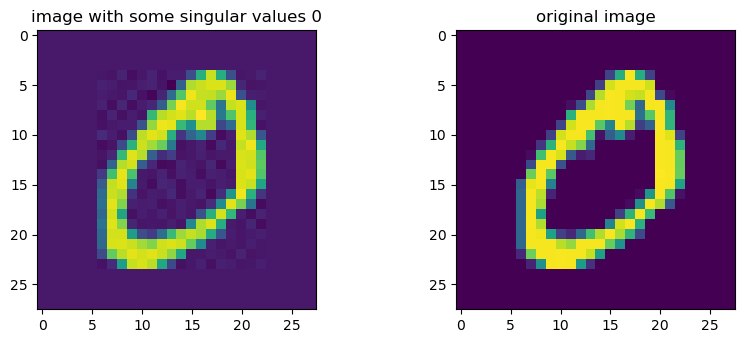

In [5]:
scopy = s.copy()
scopy[10:] = 0.0

im_0 = u.dot(np.diag(scopy)).dot(v)

plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.imshow(im_0)
plt.title('image with some singular values 0')

plt.subplot(1,2,2)
plt.imshow(im)
plt.title('original image')
_ = plt.subplots_adjust(wspace=0.5)
plt.show()

d) Consider the entire dataset as a matrix. Perform SVD and explain why / how you chose a particular rank. Note: you may not be able to run this on the entire dataset in a reasonable amount of time so you may take a small random sample for this and the following questions. (5 points)

In [23]:
u2,s2,v2 = np.linalg.svd(X, full_matrices = False)
s2[10:] = 0
svd = u2.dot(np.diag(s2)).dot(v2)

10 is a good choice of rank both keeps important information in dataset and reduces the size of dataset.

e) As in homework 2, using Kmeans on this new dataset, cluster the images from d) using 10 clusters and plot the centroid of each cluster. Note: the centroids should be represented as images. (10 points)

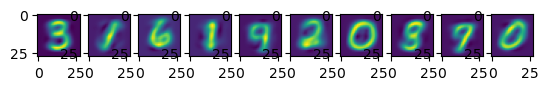

In [24]:
from sklearn.cluster import KMeans

kmeans_svd = KMeans(n_clusters = 10).fit(svd)
centroids_svd = kmeans_svd.cluster_centers_

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(centroids_svd[i].reshape(28,28))  

f) Repeat e) on the original dataset (if you used a subset of the dataset, keep using that same subset). Comment on any differences (or lack thereof) you observe between the centroids. (5 points)

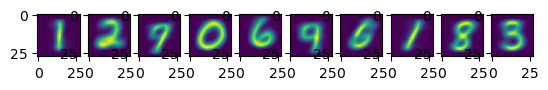

In [19]:
kmeans = KMeans(n_clusters = 10).fit(X)
centroids = kmeans.cluster_centers_

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(centroids[i].reshape(28,28)) 

The clustering on the SVD is not as clear as the clustering done on the original dataset. This is because in SVD dataset, we choose rank 10 and reduces a lot of data, making the pictures vague.

g) Create a matrix (let's call it `O`) that is the difference between the original dataset and the rank-10 approximation of the dataset. (5 points)

In [48]:
matrix_0 = np.subtract(X, svd)
matrix_0

array([[-2.62272593e-15,  4.66838386e-13,  9.04044940e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.46363890e-15,  4.17370361e-13,  9.53894994e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.88487181e-16,  1.33529126e-13, -3.26950526e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 6.60028706e-16,  2.82923081e-13, -5.82529769e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.59076933e-16,  2.54046467e-13,  3.25914957e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.02674393e-16,  4.43475791e-13, -4.58751827e-14, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

h) The largest (using euclidean distance from the origin) rows of the matrix `O` could be considered anomalous data points. Briefly explain why. Plot the 10 images responsible for the 10 largest rows of that matrix `O`. (10 points)

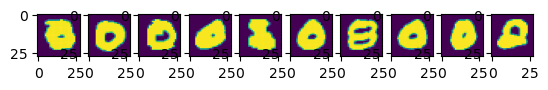

In [64]:
x_df = pd.DataFrame(X)
x_df["euclidean_distance"] = x_df.apply(lambda x : np.linalg.norm(x), axis=1)
i = 0
for _,data in x_df.nlargest(10, 'euclidean_distance').iterrows():
    plt.subplot(1, 10, i + 1)
    plt.imshow(np.array(data[:-1]).reshape(28,28))
    i+=1

## Exercise 3 (25pts)

For this question we will re-use the "mnist_784" dataset.

a) Begin by creating a training and testing datasest from our dataset, with a 80-20 ratio, and random_state=1. You can use the `train_test_split` function from sklearn. By holding out a portion of the dataset we can evaluate how our model generalizes to unseen data (i.e. data it did not learn from). **- 2 Points**

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np

X, y = fetch_openml(name="mnist_784", version=1, return_X_y=True, as_frame=False)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

b) For K ranging from 1 to 20:

1. train a KNN on the training data - **2 points**
2. record the training and testing accuracy - **2 points**

Plot a graph of the training and testing set accuracy as a function of the number of neighbors K (on the same plot). Which value of K is optimal? Briefly explain.  **- 4 points**

Optimal k: 4       Best Accuracy: 0.9741428571428571
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9723571428571428, 0.9723571428571428, 0.9736428571428571, 0.9741428571428571, 0.9736428571428571, 0.9736428571428571, 0.9715714285714285, 0.9719285714285715, 0.9702142857142857, 0.9705, 0.9677142857142857, 0.9685714285714285, 0.9665714285714285, 0.967, 0.9649285714285715, 0.9652142857142857, 0.9643571428571428, 0.9639285714285715, 0.9632142857142857, 0.9628571428571429]


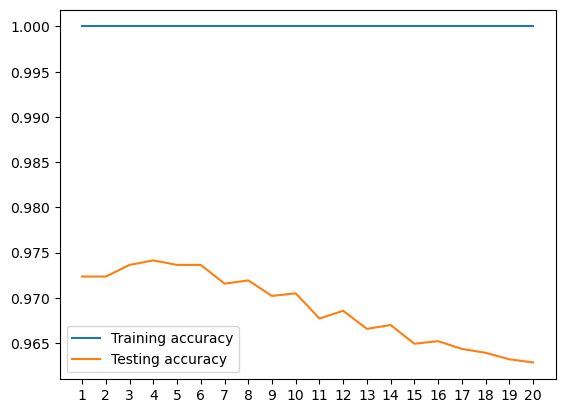

In [28]:
from sklearn.neighbors import KNeighborsClassifier    

train_accuracy, test_accuracy = [], []
for k in range(1,21):
    model = KNeighborsClassifier(n_neighbors=k, weights='distance').fit(x_train, y_train)
    train_accuracy.append(model.score(x_train,y_train))
    test_accuracy.append(model.score(x_test,y_test))

best_test_accuracy_K, best_test_accuracy = np.argmax(test_accuracy)+1, max(test_accuracy)
print('Optimal k:', best_test_accuracy_K, '      Best Accuracy:', best_test_accuracy)
print(train_accuracy)
print(test_accuracy)
plt.plot(range(1, 21), train_accuracy, label='Training accuracy')
plt.plot(range(1, 21), test_accuracy, label='Testing accuracy')
plt.xticks(range(1, 21))
plt.legend()
plt.show()

Based on the plot of the testing accuracy, k=4 is optimal since we get the highest test accuracy when setting k to 4.

c) Using the best model from b), pick an image at random and plot it next to its K nearest neighbors (5pts)

In [32]:
best_model = KNeighborsClassifier(n_neighbors=best_test_accuracy_K, weights='distance').fit(x_train, y_train)

(70000, 784)
66683


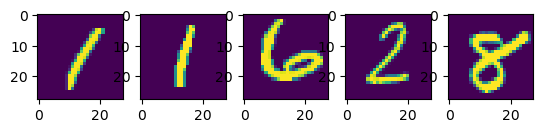

In [43]:
import random
data_size = X.shape
print(data_size)
random_index = random.randint(0, data_size[0])
print(random_index)

_, neighbors = best_model.kneighbors([X[random_index]])
plt.subplot(1,best_test_accuracy_K+1,1)
plt.imshow(X[random_index].reshape(28, 28))
i = 2
for n in neighbors[0]:
    plt.subplot(1,best_test_accuracy_K+1,i)
    plt.imshow(X[n].reshape(28, 28))
    i += 1
plt.show()

The first image is a random image in dataset and the second to fifth image are the most K nearest neighbors. In this case, K = 4.

d) Using a dimensionality reduction technique discussed in class, reduce the dimensionality of the dataset before applying a KNN model. Repeat b) and discuss similarities and differences to the previous model. Briefly discuss your choice of dimension and why you think the performance / accuracy of the model has changed. (10 points)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Optimal k: 4       Best Accuracy: 0.9756428571428571
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9741, 0.9741, 0.975057142857143, 0.9756428571428571, 0.9746285714285715, 0.9749857142857143, 0.9739285714285714, 0.9741285714285715, 0.9731142857142856, 0.9731285714285715, 0.9717428571428572, 0.9717714285714285, 0.9705714285714286, 0.9708142857142856, 0.9697142857142858, 0.9698285714285714, 0.9687000000000001, 0.968657142857143, 0.9677857142857142, 0.9677714285714286]


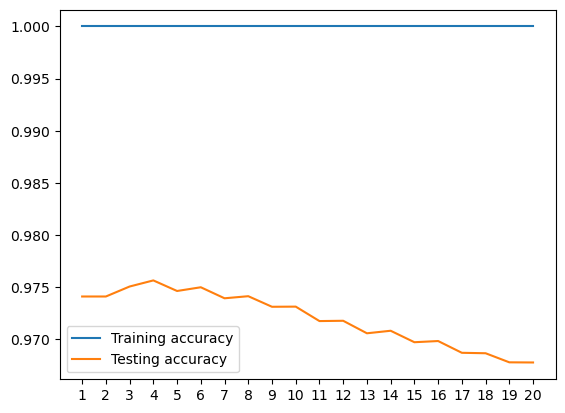

In [47]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA

train_accuracy, test_accuracy = [], []
for k in range(1,21):
    print(k)
    model = make_pipeline(PCA(n_components=0.9), KNeighborsClassifier(n_neighbors=k, weights='distance'))
    accuracy = cross_validate(model, X, y, n_jobs=-1, return_train_score=True)
    train_accuracy.append(accuracy['train_score'].mean())
    test_accuracy.append(accuracy['test_score'].mean())

best_test_accuracy_K, best_test_accuracy = np.argmax(test_accuracy)+1, max(test_accuracy)
print('Optimal k:', best_test_accuracy_K, '      Best Accuracy:', best_test_accuracy)
print(train_accuracy)
print(test_accuracy)
plt.plot(range(1, 21), train_accuracy, label='Training accuracy')
plt.plot(range(1, 21), test_accuracy, label='Testing accuracy')
plt.xticks(range(1, 21))
plt.legend()
plt.show()

By utilizing Principal Component Analysis (PCA) dimensionality reduction, dataset used for training is smaller than the original one while still containing its information and feature. 

Just like part b), based on the plot of the testing accuracy, k=4 is optimal since we get the highest test accuracy when setting k to 4. Compared to b)'s 97.414% testing accuracy, we have 97.564% testing accuracy after doing PCA dimensionality reduction, which is a little bit better. The shape of testing accuracy line is almost the same with the one without PCA.

## Bonus (20 points)

Complete the code below to support N-dimensional GMM clustering. Only use the methods imported below. Please take a look at the comments and docstrings for more info.

In [ ]:
from numpy import array, argmax
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from numpy.random import multivariate_normal, uniform

nd_gmm = [
    Component(.25, [-1, 1], [[1, 0], [0, 1]]),
    Component(.50, [0, 0], [[1, 0], [0, 1]]),
    Component(.25, [1, 1], [[1, 0], [0, 1]])
]

def generate_nd_gmm_dataset(gmm_params, size):
    if not is_valid_nd_gmm(gmm_params):
        raise ValueError("GMM parameters are invalid")
    
    dataset = []
    for _ in range(size):
        comp = get_random_component(gmm_params)
        dataset += ...
    return dataset # this should be a numpy array instead of a list


def is_valid_nd_gmm(gmm_params):
    '''
        Check that all the dimensions are consistent
        accross all components
    '''
    ...
    return is_valid_gmm(gmm_params) # checks if mixture components add to 1


def gmm_nd_init(k, dataset):
    kmeans = KMeans(k, init='k-means++').fit(X=...)
    gmm_params = []
    ...
    return gmm_params


def compute_nd_gmm(k, dataset, probs):
    '''
        Compute P(C_j), mean_j, var_j

        Here mean_j is a vector and var_j is a matrix
    '''
    gmm_params = []
    ...
    return gmm_params


def compute_nd_probs(k, dataset, gmm_params):
    '''
        For all x_i in dataset, compute P(C_j | X_i)
        = P(X_i | C_j)P(C_j) / P(X_i) for all C_j
        return the list of lists of all P(C_j | X_i)
        for all x_i in dataset.
        
        Here x_i are vectors
    '''
    probs = []
    ...
    return probs


def expectation_maximization_nd(k, dataset, iterations):
    '''
        Repeat for a set number of iterations.
    '''
    gmm_params = gmm_nd_init(k, dataset)
    for _ in range(iterations):
        # expectation step
        probs = compute_nd_probs(k, dataset, gmm_params)

        # maximization step
        gmm_params = compute_nd_gmm(k, dataset, probs)

    return probs, gmm_params


data = generate_nd_gmm_dataset(nd_gmm, 100)
probs, gmm_p = expectation_maximization_nd(2, data, 3)
labels = [argmax(array(p)) for p in probs] # create a hard assignment
size = 50 * array(probs).max(1) ** 2
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=size)
plt.show()